# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

2024-04-16 16:33:15.171132: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 16:33:15.180908: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 16:33:15.323021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 16:33:17.966246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res


### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

np.random.seed(42)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.371634556838659

### c)

In [8]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [9]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(128)(layer_out)
# layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [11]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0590 - val_loss: 0.0021
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0101 - val_loss: -0.0339
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0469 - val_loss: -0.0508
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0606 - val_loss: -0.0595
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0659 - val_loss: -0.0646
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0799 - val_loss: -0.0678
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.0832 - val_loss: -0.0698
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0809 - val_loss: -0.0715
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0740 - val_loss: -0.0731
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0810 - val_loss: -0.0746
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0854 - val_loss: -0.0758
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2

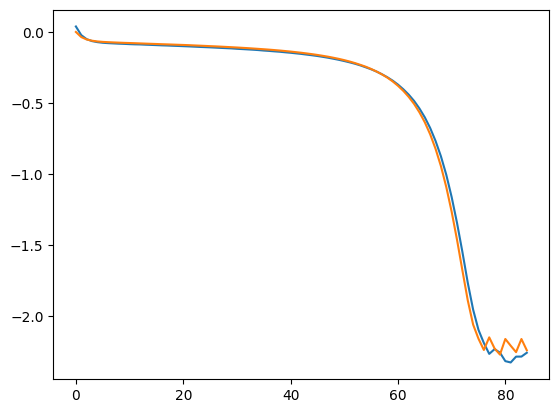

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [13]:
t_x_pred = model.predict(x)[:,0]

151/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [14]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

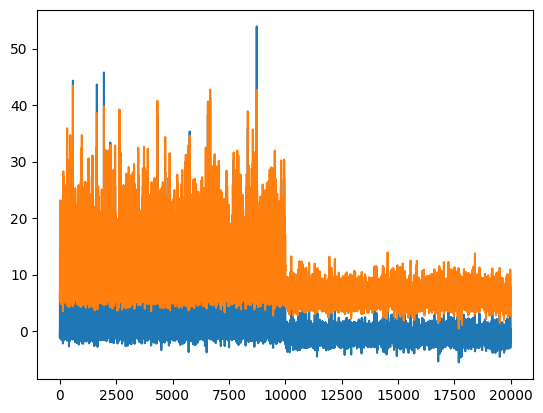

In [15]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

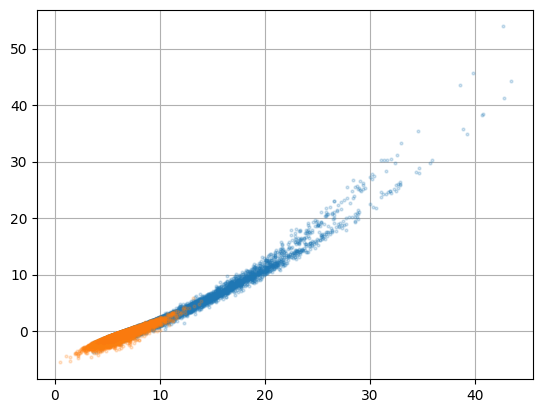

In [16]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

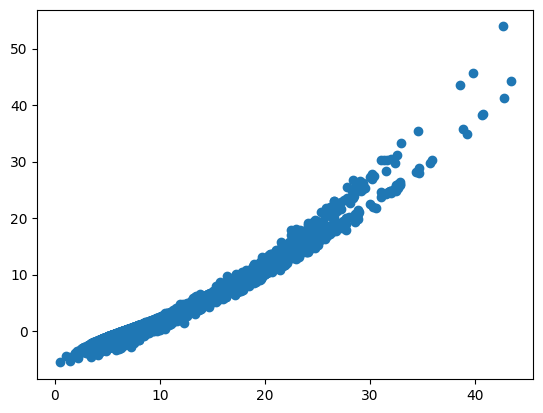

In [17]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [18]:
DV_fun(y, t_x_pred)

2.2707796317730393

In [19]:
DV_fun(y, t_x_opt)

2.371634556838659

In [20]:
# new data

x_new = np.concatenate([
    np.random.multivariate_normal(mu1, Sigma1, size=n),
    np.random.multivariate_normal(mu2, Sigma2, size=n)
]
)
y_new = np.repeat([1, 0], n)

In [21]:
t_x_pred = model.predict(x_new)[:,0]

173/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [22]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [23]:
DV_fun(y_new, t_x_pred)

2.163111797939999

In [24]:
DV_fun(y_new, t_x_opt)

2.3396448140680217

### f)

In [39]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true)) / n1
    second_term = (
        tf.math.reduce_sum(
            tf.math.multiply(
                tf.math.exp(tf.subtract(T_x, tf.convert_to_tensor(1.0))),
                tf.subtract(tf.convert_to_tensor(1.0), y_true),
            )
        ) / n2
    )
    return -(first_term - second_term)

In [40]:
def NWJ_fun(y, t):
    return np.mean(t[y==1])-np.mean(np.exp(t[y==0]-1))

In [41]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
# layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=5e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [43]:
hist = model.fit(x_train, y_train, epochs=256, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/256


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1201 - val_loss: -0.0235
Epoch 2/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0409 - val_loss: -0.0323
Epoch 3/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0426 - val_loss: -0.0390
Epoch 4/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0548 - val_loss: -0.0448
Epoch 5/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.0554 - val_loss: -0.0494
Epoch 6/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0560 - val_loss: -0.0537
Epoch 7/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.0624 - val_loss: -0.0572
Epoch 8/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0627 - val_loss: -0.0602
Epoch 9/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0678 - val_loss: -0.0632
Epoch 10/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0702 - val_loss: -0.0657
Epoch 11/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0640 - val_loss: -0.0677
Epoch 12/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 

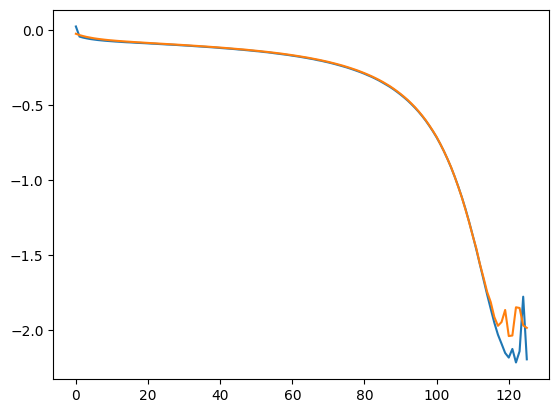

In [44]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [45]:
t_x_pred = model.predict(x)[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [46]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2) + 1

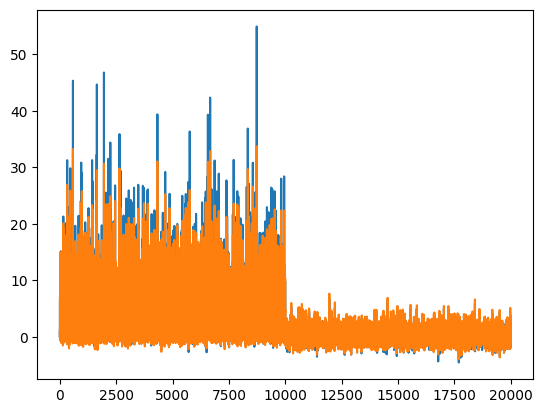

In [47]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

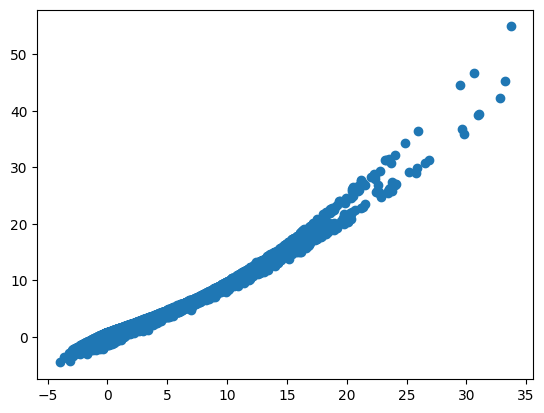

In [48]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [49]:
NWJ_fun(y, t_x_pred)

2.235735

In [50]:
NWJ_fun(y, t_x_opt)

2.3662098988145295